[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/tyson-swetnam/agic-2022/blob/main/docs/notebooks/cog.ipynb)
[![image](https://mybinder.org/badge_logo.svg)](https://tyson-swetnam.github.io/agic-2022/notebooks/cog/)

Creating Cloud Optimized GeoTIFF

## Using Cloud Optimized GeoTIFF Files (COG) Examples.

We show how to read COG files with the [**rasterio**](https://rasterio.readthedocs.io/en/latest/index.html) Library for Python.


We will use the [**satsearch**](https://github.com/sat-utils/sat-search) library for discovering and downloading publicly available satellite imagery using [**STAC**](https://stacspec.org/en/tutorials/intro-to-stac/) compliant API.

[**STAC**](https://stacspec.org/en/) is the **SpatioTemporal Assets Catalog** specification that provides a common structure for describing and cataloging spatiotemporal assets.

A _spatiotemporal asset_ is any file that represents information about the earth captured in a certain space and time.

## References

* Abdishakur (2021) [Cloud Optimized GeoTIFF (COG) with Python](https://medium.com/spatial-data-science/cloud-optimized-geotiff-cog-with-python-8e0a22b884c5). Medium (Spatial Data Science).
* Andrew Cutts (2021). [STAC, COG, Python and QGIS](http://www.acgeospatial.co.uk/stac-cog-python-and-qgis/). acgeospatial Blog.
* [Cloud Optimized GeoTIFF](https://www.cogeo.org/)
* [STAC - SpatioTemporal Assets Catalog](https://stacspec.org/en/). 



In [ ]:
# Install requirements
!pip install python-dateutil

In [ ]:
# Install satsearch library

!pip install sat-search --quiet

# Please restart Runtime Environment after downloading


In [ ]:
# Install the rasterio library 
!pip install rasterio --quiet


In [4]:
#!pip install gdalinfo


In [5]:
# Import necessary libraries 

from satsearch import Search
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt


_Satsearch_ can take _bounding boxes_ or [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) like Polygon. So let us start with a simple bounding box. We are using the [Element48](https://www.element84.com/) free [Sentinel 2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) data STAC API available in _Amazon AWS_ for free, but you can use any public STAC API endpoint.

## Example using BoundingBox coordinates.

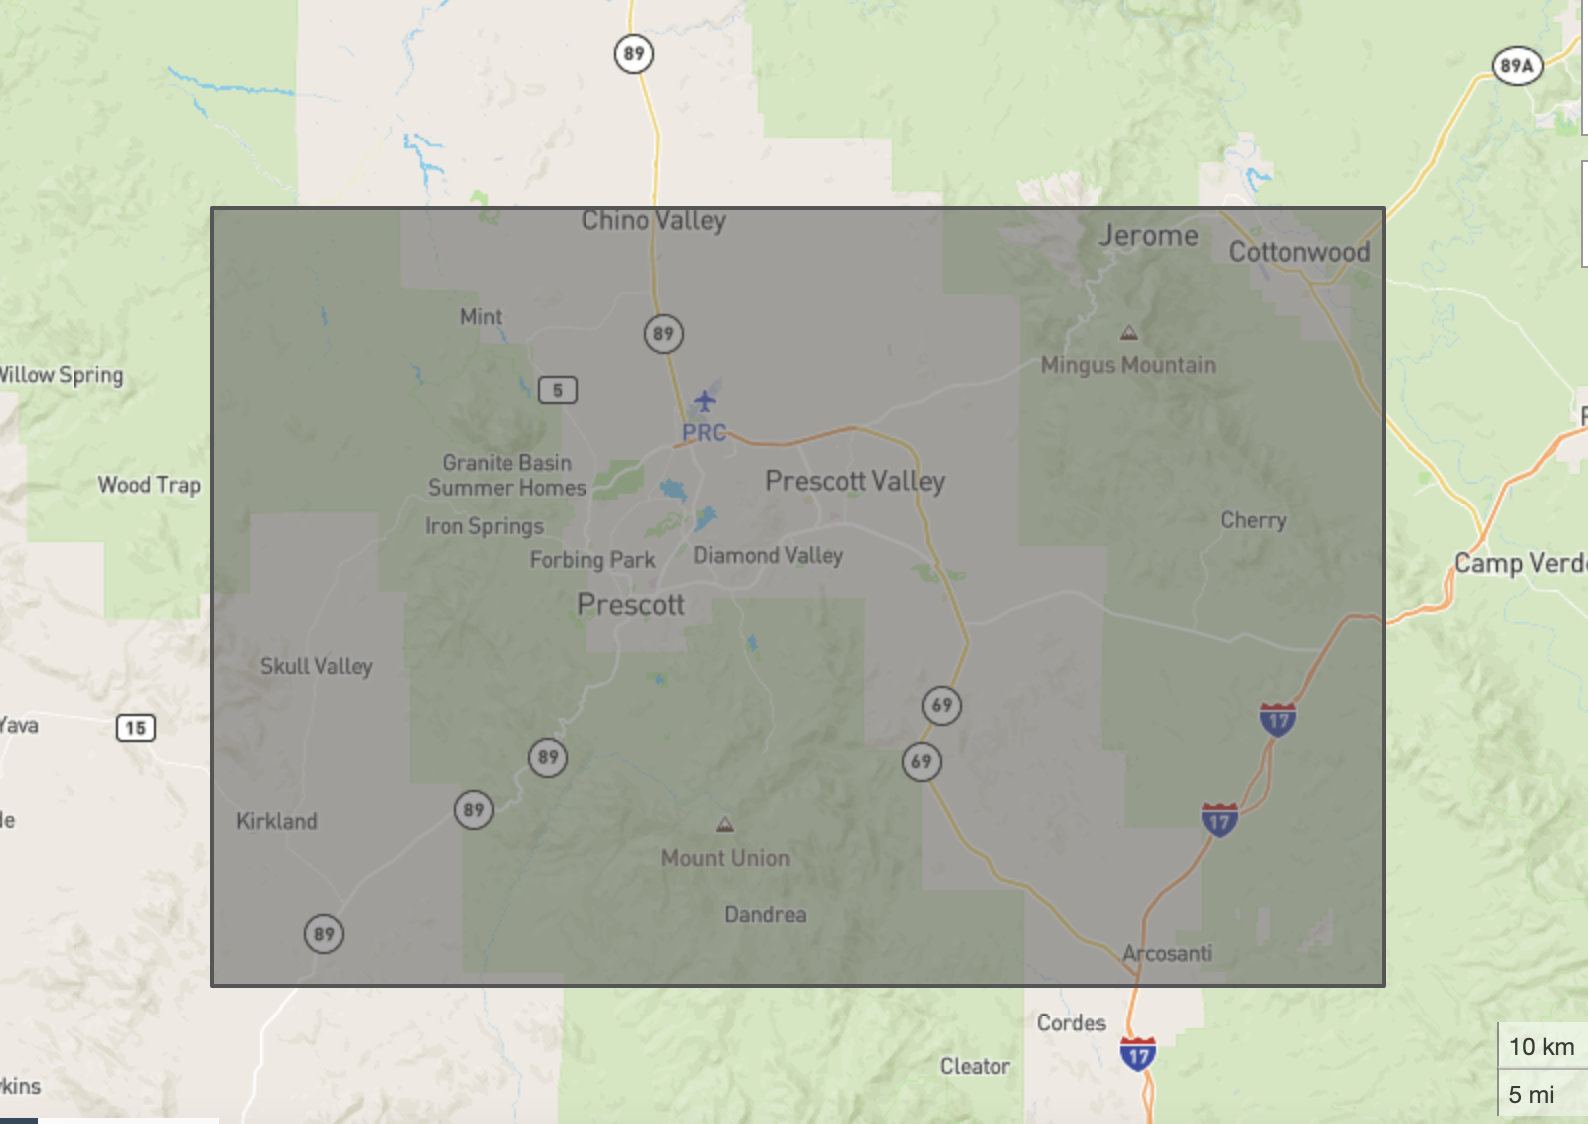

In [46]:
bbox =  [ -111.94381713867186,
           34.36951139880403,
          -112.75680541992188,
           34.838604318634985]  

url = 'https://earth-search.aws.element84.com/v0'

bbox_search = Search(bbox=bbox,  url=url)

print('Query returned {} items'.format(bbox_search.found()))

Query returned 2217 items


You can limit the data with other parameters like dates and cloud coverage. So let us add these parameters to the query, by asking for images between January to February 2021, with less than 5% cloud coverage.


In [47]:
bbox_search = Search(bbox=bbox, datetime="2021-01-01/2021-02-01", 
                     query={'eo:cloud_cover': {'lt': 5}}, url=url)

print('Query returned {} items'.format(bbox_search.found()))

Query returned 6 items


In [48]:

bbox_search = Search(
    bbox=bbox,
    datetime="2020-10-01/2021-02-01",
    query={"eo:cloud_cover": {"lt": 1}},
    collections=["sentinel-s2-l2a-cogs"],
    url=url,
)
items = bbox_search.items()

# Select first item
print(items[0].assets)


{'overview': {'proj:shape': [343, 343], 'proj:transform': [320, 0, 399960, 0, -320, 3900000, 0, 0, 1], 'roles': ['overview'], 'eo:bands': [{'full_width_half_max': 0.038, 'center_wavelength': 0.6645, 'name': 'B04', 'common_name': 'red'}, {'full_width_half_max': 0.045, 'center_wavelength': 0.56, 'name': 'B03', 'common_name': 'green'}, {'full_width_half_max': 0.098, 'center_wavelength': 0.4966, 'name': 'B02', 'common_name': 'blue'}], 'gsd': 10, 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/VD/2021/1/S2A_12SVD_20210127_0_L2A/L2A_PVI.tif', 'title': 'True color image', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}, 'thumbnail': {'roles': ['thumbnail'], 'href': 'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/12/S/VD/2021/1/27/0/preview.jpg', 'title': 'Thumbnail', 'type': 'image/png'}, 'metadata': {'roles': ['metadata'], 'href': 'https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/12/S/VD/2021/1/27/0/metadata.xml', 'title': 'Orig

In the above results we search for the URL addresses for the B04 and B08 Cloud Optimized GeoTIFF bands, that needed for computing the NDVI (Normalized Difference Vegetation Index). 

Then we open and read the specific online COG files with the `rasterio` library to compute the NDVI.

In [49]:
# We can compute the NDVI (Normalized Difference Vegetation Index) using the red and near infrarred bands
# Read and open (B04 and B08) bands

#b4 = rio.open(items[0].asset(“red”)[“href”])
#b8 = rio.open(items[0].asset(“nir”)[“href”])

# Red band B04.tif
urlB04 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/VD/2021/1/S2A_12SVD_20210127_0_L2A/B04.tif'
# Near infrarred band B08.tif
urlB08 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/VD/2021/1/S2A_12SVD_20210127_0_L2A/B08.tif'
b4 = rio.open(urlB04)
b8 = rio.open(urlB08)

red = b4.read()
nir = b8.read()
# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


We display the NDVI visualization

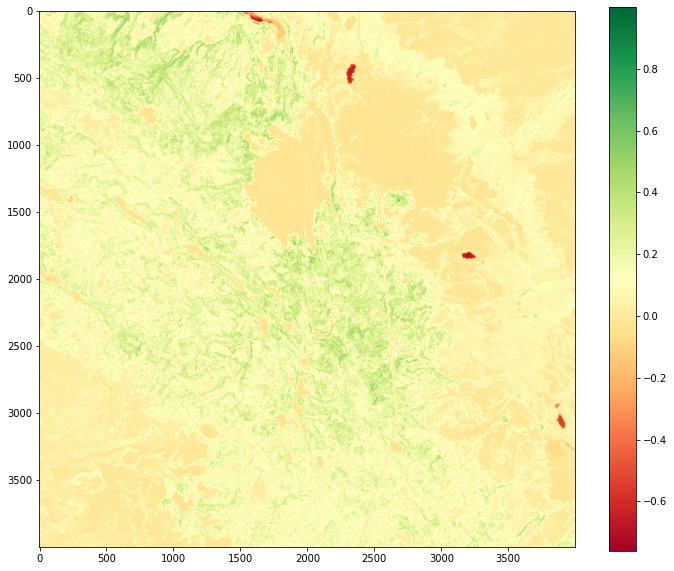

In [50]:
fig, ax = plt.subplots(figsize=(12,10))
#show(ndvi[0, 2000:6000, 4000:8000],cmap='RdYlGn', ax=ax)
plt.imshow(ndvi[0, 2000:6000, 4000:8000] ,cmap='RdYlGn')
plt.colorbar()
plt.show()


## Example using GeoJSON



In [14]:
# Willl need geopandas
!pip install geopandas --quiet


     |████████████████████████████████| 1.0 MB 27.8 MB/s 
     |████████████████████████████████| 16.7 MB 59.0 MB/s 
     |████████████████████████████████| 6.3 MB 56.2 MB/s 


## Case study: Catalina Mountains

We can use the tool [geoson.io](https://geojson.io/#map=11/32.3843/-110.7968), to generate GeoJSON files for any desired study area. Here a Polygon is shown as the  area of study. 

We then saved the GeoJSON as `map.geoson` and uploaded to a Github.com repository, from where we will read the online geojson file. 

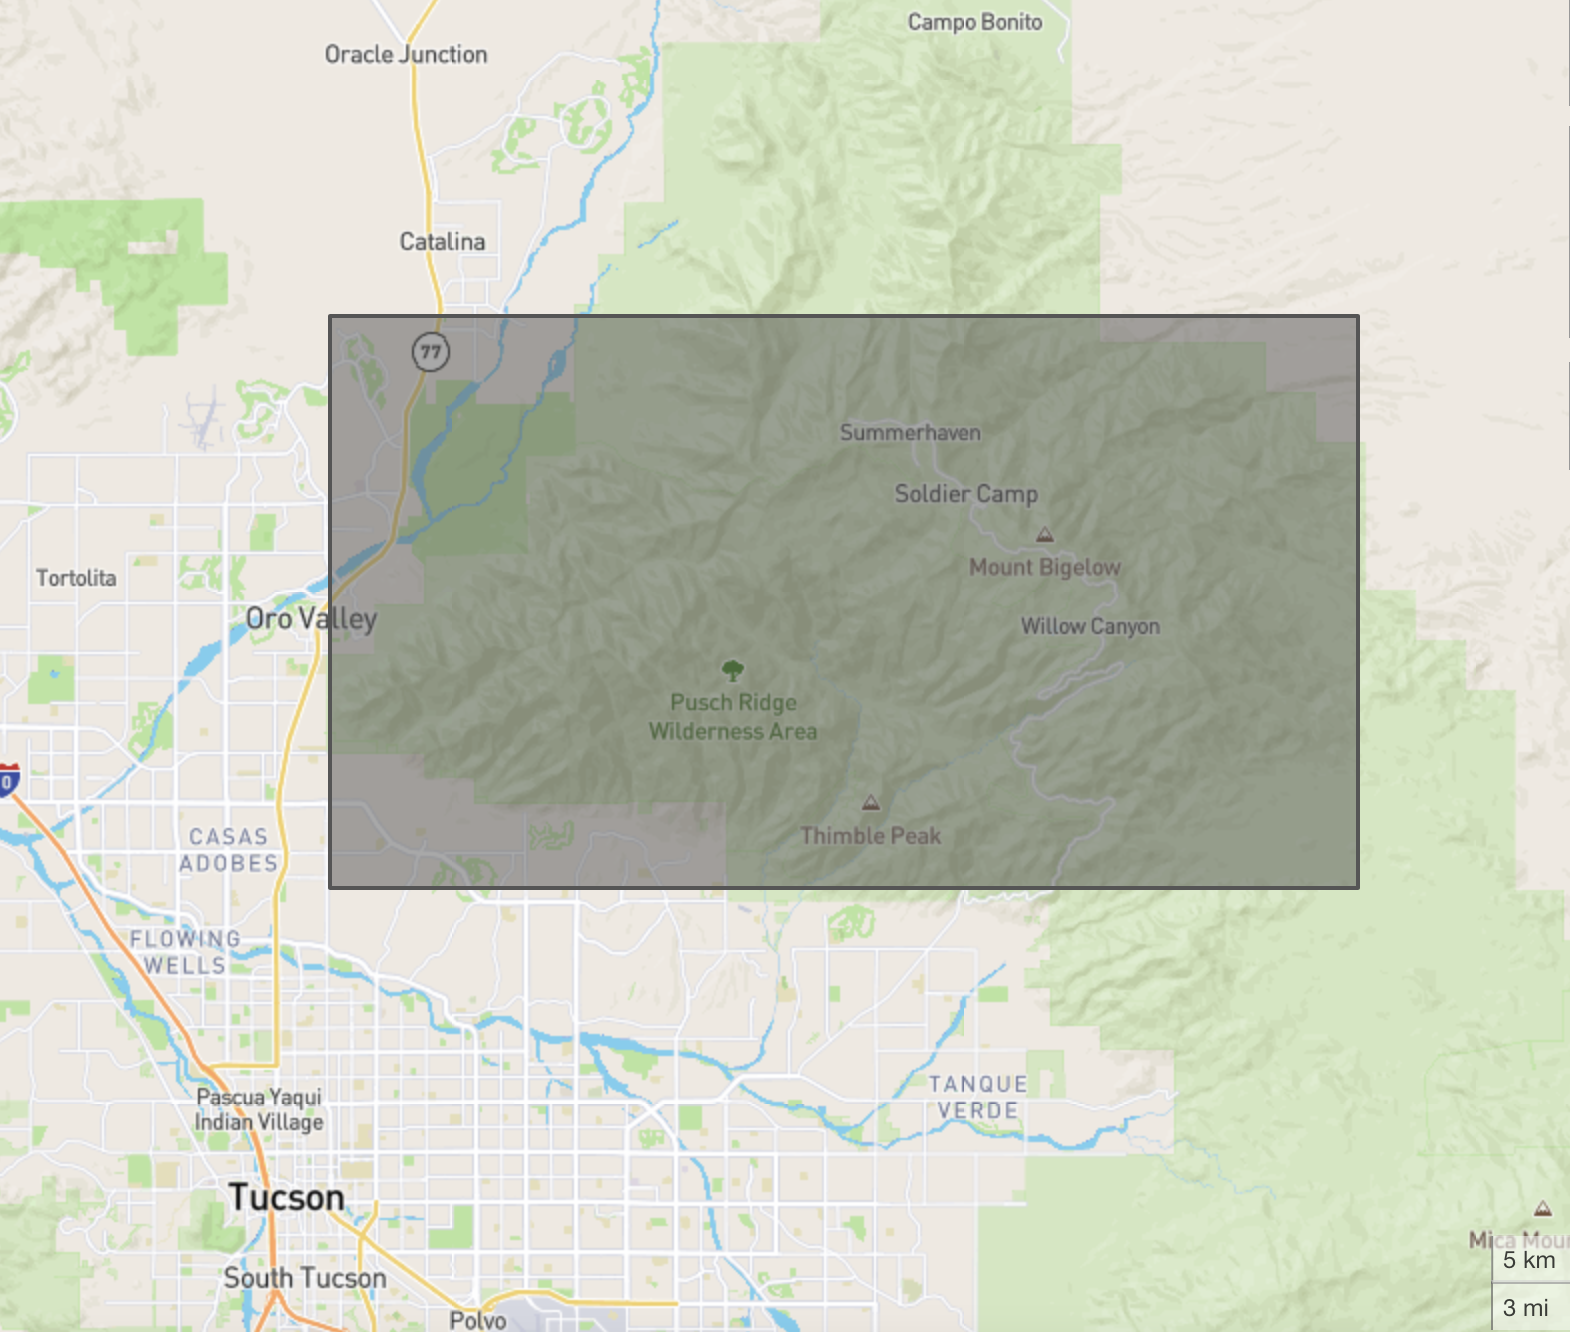

Will read a GeoJSON file for this polygon, and use Geopandas to extract bounding box coordinates.

In [15]:
import geopandas as gpd

gdf = gpd.read_file('https://raw.githubusercontent.com/clizarraga-UAD7/Datasets/main/map.geoson')
bounds = gdf.bounds
print(bounds['minx'])
boundary = bounds.values.tolist()
print(boundary[0])


0   -110.959854
Name: minx, dtype: float64
[-110.95985412597656, 32.312670050625805, -110.60691833496094, 32.47848770270873]


Using these cooordinates to Search the Sentinel 2 image catalog and select region. 

In [16]:
search = Search(bbox=boundary[0], url='https://earth-search.aws.element84.com/v0')
print('bbox search: %s items' % search.found())


bbox search: 4322 items


THere are 4322 available images. We will filter out images between 2020-05-01 and 2020-07-30 with less than 5% of cloud cover.

In [17]:
search = Search(bbox=boundary[0], datetime='2020-05-01/2020-07-30', 
                     query={'eo:cloud_cover': {'lt': 5}}, 
                url='https://earth-search.aws.element84.com/v0')
print('bbox search: %s items' % search.found())


bbox search: 148 items


We have a nice set of 148 images that satisfy previous requirements.

In [18]:
items = search.items()
print('%s items' % len(items))
print('%s collections' % len(items._collections))
print(items._collections)


148 items
3 collections
[sentinel-s2-l2a-cogs, sentinel-s2-l2a, sentinel-s2-l1c]


We will work with the COG collection: `sentinel-s2-l2a-cogs`

In [33]:
search = Search(bbox=boundary[0], datetime='2020-05-01/2020-07-30', collections=['sentinel-s2-l2a-cogs'], query={'eo:cloud_cover': {'lt': 5}}, url='https://earth-search.aws.element84.com/v0')
print('bbox search: %s items' % search.found())


bbox search: 49 items


We can analyze the images and select the date with no cloud cover

In [34]:
items = search.items()
print(items.summary(['date', 'id', 'eo:cloud_cover'])) 


Items (49):
date                      id                        eo:cloud_cover            
2020-07-28                S2A_12SVA_20200728_0_L2A  1.67                      
2020-07-28                S2A_12SVB_20200728_0_L2A  0.99                      
2020-07-18                S2A_12SWB_20200718_0_L2A  4.43                      
2020-07-08                S2A_12SVA_20200708_0_L2A  0.35                      
2020-07-08                S2A_12SWA_20200708_0_L2A  1.63                      
2020-07-08                S2A_12SVB_20200708_0_L2A  0.36                      
2020-07-08                S2A_12SWB_20200708_0_L2A  0.85                      
2020-07-03                S2B_12SVA_20200703_0_L2A  4.25                      
2020-07-03                S2B_12SWA_20200703_0_L2A  4.45                      
2020-06-28                S2A_12SVA_20200628_0_L2A  0.04                      
2020-06-28                S2A_12SWA_20200628_0_L2A  0                         
2020-06-28                S2A_12SVB_2020

The image from 2020-06-28 (S2A_12SWA_20200628_0_L2A= has 0 cloud cover. This is the 10th. image (start counting from 0)  

In [36]:
print(type(items[10]))
print(items[10])


<class 'satstac.item.Item'>
S2A_12SWA_20200628_0_L2A


In [ ]:
print(items[10].assets)

To compute the NDVI values, we need to download the Red and NIR bands.

In [40]:
print(items[10].asset('red'))
print(items[10].asset('nir'))


{'proj:shape': [10980, 10980], 'proj:transform': [10, 0, 499980, 0, -10, 3600000, 0, 0, 1], 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WA/2020/6/S2A_12SWA_20200628_0_L2A/B04.tif', 'title': 'Band 4 (red)', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}
{'proj:shape': [10980, 10980], 'proj:transform': [10, 0, 499980, 0, -10, 3600000, 0, 0, 1], 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WA/2020/6/S2A_12SWA_20200628_0_L2A/B08.tif', 'title': 'Band 8 (nir)', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}


In [41]:
# Define files URLs
file_urlB04 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WA/2020/6/S2A_12SWA_20200628_0_L2A/B04.tif'
file_urlB08 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WA/2020/6/S2A_12SWA_20200628_0_L2A/B08.tif'


Now we are able of computing the NDVI value for each pixel in the study region

In [42]:
b4 = rio.open(file_urlB04)
b8 = rio.open(file_urlB08)

red = b4.read()
nir = b8.read()
# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


We can view a thumbnail of any of the bands, we select the Red band.

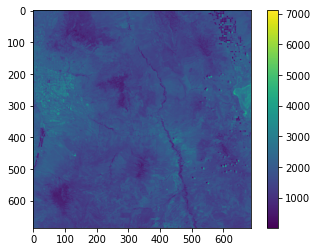

In [43]:
%matplotlib inline
import rasterio
import matplotlib.pyplot as plt
with rasterio.open(file_urlB04) as src:
   # List of overviews from biggest to smallest
   oviews = src.overviews(1)
   # Retrieve the smallest thumbnail
   oview = oviews[-1]
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
plt.imshow(thumbnail)
plt.colorbar()


We can now show the NDVI fo the Catalina Mountains for 2020-06-28.

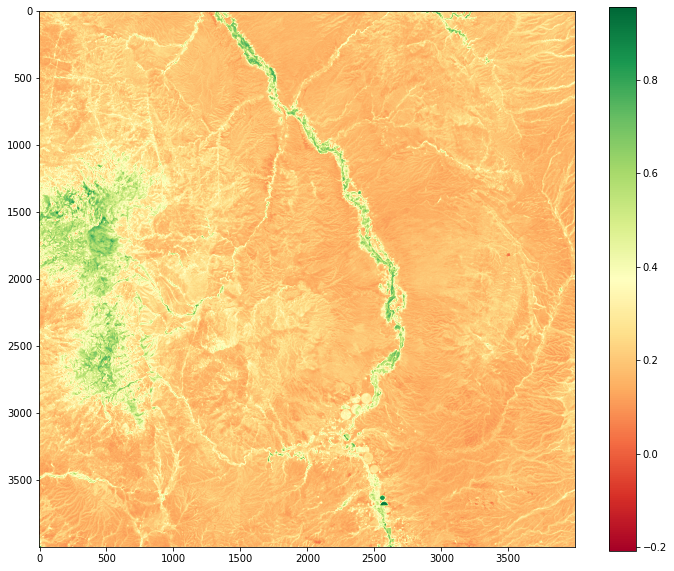

In [44]:
fig, ax = plt.subplots(figsize=(12,10))
#show(ndvi[0, 2000:6000, 4000:8000],cmap='RdYlGn', ax=ax)
plt.imshow(ndvi[0, 2000:6000, 4000:8000] ,cmap='RdYlGn')
plt.colorbar()
plt.show()
